<a href="https://colab.research.google.com/github/yashv04/Match-Simulator-Opponent-Strategy-AI/blob/main/Match_Simulator_%2B_Opponent_Strategy_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implement ball-by-ball match simulator (Markov Chains).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
deliveries = pd.read_csv('deliveries_updated_mens_ipl.csv')
matches = pd.read_csv('matches_updated_mens_ipl.csv')

In [3]:
df = deliveries.copy()
df = df.rename(columns = {'matchId' : 'match_id', 'batsman_runs' : 'runs_off_bat', 'dismissal_kind': 'wicket_type'})

In [4]:
# Step 1: Feature Engineering
df['ball_number'] = df['over'] * 6 + df['ball'] - 1
df['is_wicket'] = df['wicket_type'].notnull().astype(int)
df['runs_cumsum'] = df.groupby('match_id')['runs_off_bat'].cumsum()
df['wickets_cumsum'] = df.groupby('match_id')['is_wicket'].cumsum()

In [5]:
# Step 2: Create next state columns
df['next_runs'] = df['runs_cumsum'].shift(-1)
df['next_wickets'] = df['wickets_cumsum'].shift(-1)
df['next_ball'] = df['ball_number'].shift(-1)
df['next_match_id'] = df['match_id'].shift(-1)
df = df[df['match_id'] == df['next_match_id']]
df.dropna(subset=['next_runs', 'next_wickets', 'next_ball'], inplace=True)

In [6]:
# Step 3: Build Markov Chain transitions
state_transitions = {}
for _, row in df.iterrows():
    current_state = (int(row['runs_cumsum']), int(row['wickets_cumsum']), int(row['ball_number']))
    next_state = (int(row['next_runs']), int(row['next_wickets']), int(row['next_ball']))
    if current_state not in state_transitions:
        state_transitions[current_state] = []
    state_transitions[current_state].append(next_state)

# Step 4: Convert transitions to probabilities
for state, transitions in state_transitions.items():
    unique_transitions = list(set(transitions))
    probabilities = [transitions.count(t) / len(transitions) for t in unique_transitions]
    state_transitions[state] = (unique_transitions, probabilities)

In [7]:
# Step 5: Simulation function
def simulate_match(start_state=(0, 0, 0), max_balls=120):
    current_state = start_state
    match_states = [current_state]
    while current_state[2] < max_balls and current_state[1] < 10:
        if current_state in state_transitions:
            next_states, probabilities = state_transitions[current_state]
            current_state = random.choices(next_states, probabilities)[0]
            match_states.append(current_state)
        else:
            break
    return match_states

In [119]:
simulated_match = simulate_match(start_state=(0, 0, 0))
simulated_df = pd.DataFrame(simulated_match, columns=['Runs', 'Wickets', 'Balls'])

# Output: Last 10 states
print(simulated_df.tail(10))

     Runs  Wickets  Balls
115   154        5    111
116   155        5    112
117   156        5    113
118   160        5    114
119   166        5    115
120   167        5    116
121   173        5    117
122   179        5    118
123   180        5    119
124   180        6    120


#Enhancing the Cricket Match Simulator

In [9]:
# Modify state transitions to include venue & opponent factors
venue_factors = {'Wankhede': 1.1, 'Chepauk': 0.9, 'Chinnaswamy': 1.2}  # Adjust run probabilities
bowler_types = {'Pace': 1.0, 'Spin': 0.8}  # Reduce runs against spin

In [10]:
def adjust_probabilities(state, next_states, probabilities, venue, bowler_type):
    # Modify run probabilities based on venue
    venue_factor = venue_factors.get(venue, 1.0)
    bowler_factor = bowler_types.get(bowler_type, 1.0)

    adjusted_probabilities = [
        prob * venue_factor * bowler_factor for prob in probabilities
    ]
    # Normalize to ensure sum = 1
    adjusted_probabilities = np.array(adjusted_probabilities) / sum(adjusted_probabilities)
    return adjusted_probabilities

In [130]:
def simulate_match_with_factors(start_state=(0, 0, 0), venue='Wankhede', bowler_type='Pace'):
    current_state = start_state
    match_states = [current_state]


    while current_state[2] < 120 and current_state[1] < 10:
        if current_state in state_transitions:
            next_states, probabilities = state_transitions[current_state]
            probabilities = adjust_probabilities(current_state, next_states, probabilities, venue, bowler_type)

            # Ensure next state's ball number doesn't exceed 120 and is unique
            valid_next_states = [state for state in next_states
                                 if state[2] <= 120 and state[2] > current_state[2]]
            if valid_next_states:
                # Adjust probabilities for valid states
                valid_probabilities = [probabilities[next_states.index(state)] for state in valid_next_states]
                # Normalize probabilities
                valid_probabilities = np.array(valid_probabilities) / sum(valid_probabilities)

                current_state = random.choices(valid_next_states, valid_probabilities)[0]
                match_states.append(current_state)
            else:
                break  # No valid next states, end simulation
        else:
            break  # Current state not found in transitions, end simulation

    return match_states

In [131]:
# Run enhanced simulation
simulated_match = simulate_match_with_factors(venue='Wankhede', bowler_type='Pace')

# Convert to DataFrame for visualization
simulated_df = pd.DataFrame(simulated_match, columns=['Runs', 'Wickets', 'Balls'])

#Visualizing the Simulation Progress

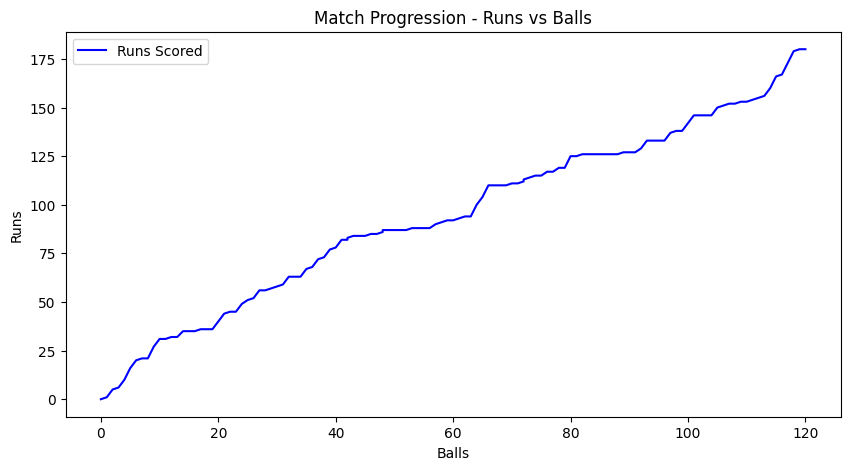

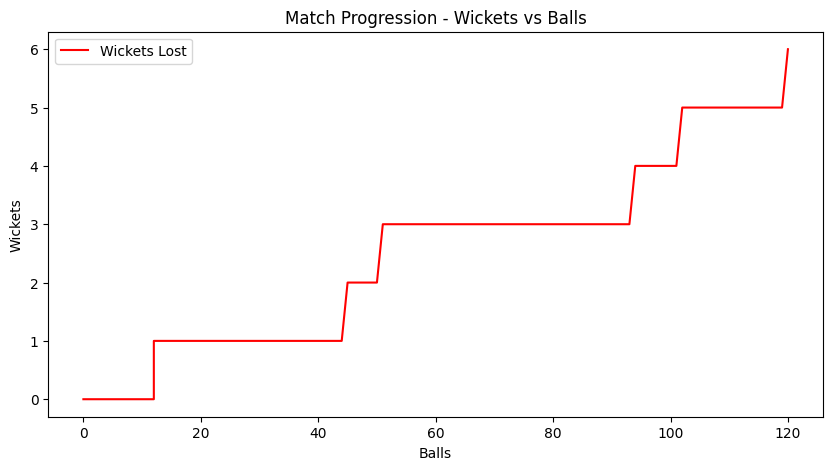

In [120]:
import matplotlib.pyplot as plt

# Plot Runs Progression
plt.figure(figsize=(10, 5))
plt.plot(simulated_df['Balls'], simulated_df['Runs'], label='Runs Scored', color='blue')
plt.xlabel('Balls')
plt.ylabel('Runs')
plt.title('Match Progression - Runs vs Balls')
plt.legend()
plt.show()

# Plot Wickets Progression
plt.figure(figsize=(10, 5))
plt.plot(simulated_df['Balls'], simulated_df['Wickets'], label='Wickets Lost', color='red')
plt.xlabel('Balls')
plt.ylabel('Wickets')
plt.title('Match Progression - Wickets vs Balls')
plt.legend()
plt.show()

#Add Match Phases: Powerplay, Middle, Death Overs

In [123]:
def get_phase(ball_number):
    over = ball_number // 6
    if over < 6:
        return 'Powerplay'
    elif over < 16:
        return 'Middle'
    else:
        return 'Death'

phase_factors = {
    'Powerplay': 1.1,
    'Middle': 1.0,
    'Death': 1.3
}

def adjust_probabilities_with_phase(state, next_states, probabilities, venue, bowler_type):
    venue_factor = venue_factors.get(venue, 1.0)
    bowler_factor = bowler_types.get(bowler_type, 1.0)
    phase = get_phase(state[2])
    phase_factor = phase_factors.get(phase, 1.0)

    adjusted_probabilities = [
        prob * venue_factor * bowler_factor * phase_factor for prob in probabilities
    ]
    adjusted_probabilities = np.array(adjusted_probabilities) / sum(adjusted_probabilities)
    return adjusted_probabilities

In [124]:
#Dynamic Bowling Changes + Strategy AI

def get_bowler_type(over):
    if over < 6 or over > 16:
        return 'Pace'
    else:
        return 'Spin'

In [125]:
# Display Match Summary
final_state = simulated_df.iloc[-1]
total_runs = final_state['Runs']
total_wickets = final_state['Wickets']
total_overs = final_state['Balls'] // 6 + (final_state['Balls'] % 6) / 10

print(f"Match Summary:")
print(f"Total: {total_runs}/{total_wickets} in {total_overs:.1f} overs")
print(f"Run Rate: {total_runs / (final_state['Balls'] / 6):.2f}")

Match Summary:
Total: 180/6 in 20.0 overs
Run Rate: 9.00


In [126]:
#Save Results & Visualize
simulated_df.to_csv('simulated_match_output.csv', index=False)

In [20]:
pip install seaborn plotly

In [127]:
import plotly.express as px

# Runs Progression
fig_runs = px.line(simulated_df, x='Balls', y='Runs',
                   title='Interactive Runs Progression',
                   labels={'Balls': 'Ball Number', 'Runs': 'Total Runs'},
                   template='plotly_dark')
fig_runs.show()

# Wickets Progression
fig_wickets = px.line(simulated_df, x='Balls', y='Wickets',
                      title='Interactive Wickets Progression',
                      labels={'Balls': 'Ball Number', 'Wickets': 'Total Wickets'},
                      template='plotly_dark')
fig_wickets.show()

In cricket, predicting the outcome of a match is not just about team strength but also about dynamic factors such as pitch behavior, match phase, and team strategies. A tactical match simulator provides an innovative way to understand how these factors evolve throughout a match.

The match simulation is based on a ball-by-ball prediction model, where each delivery outcome (runs, wickets, boundaries) is determined using probabilities derived from historical data. Players’ batting and bowling skills, along with pitch conditions, influence the outcome of each ball in real-time.

Here's the Match summary of the inning played in Wankhade, Mumbai.
Total: 180/6 in 20.0 overs
Run Rate: 9.00

he Tactical Match Simulator shows how match dynamics unfold and how each ball can change the course of a game. Future versions will incorporate live player data and more sophisticated models to predict outcomes more accurately.


#OPPONENT STRATEGY AI

Predict how an opposing team will approach the match — whether they’ll:

1. Use aggressive or conservative batting

2. Open with pace or spin

3. Rotate bowlers in a specific pattern

4. Use specific tactics in different game phases

In [22]:
matches = pd.read_csv('matches_updated_mens_ipl.csv')

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [24]:
pip install xgboost imbalanced-learn

In [96]:
deliveries = pd.read_csv("deliveries_updated_mens_ipl.csv")
matches = pd.read_csv("matches_updated_mens_ipl.csv")

In [97]:
deliveries['total_runs'] = deliveries.groupby('matchId')['batsman_runs'].cumsum()

Powerplay strategy

In [98]:
# Merge using matchId
merged_df = deliveries.merge(
    matches[['matchId', 'venue', 'toss_decision', 'team1', 'team2']],
    on='matchId',
    how='left'
)

In [99]:
powerplay_df = merged_df[merged_df['over'] <= 6]

In [100]:
# Group by match and batting team to get total runs
powerplay_runs = powerplay_df.groupby(['matchId', 'batting_team'])[['total_runs', 'ball', 'team1', 'venue', 'toss_decision']].agg({'total_runs': 'sum', 'ball': 'count', 'team1': 'first', 'venue': 'first', 'toss_decision': 'first'}).reset_index()

In [101]:
# Step 2: Feature Engineering – Calculate run rate in powerplay
powerplay_runs['run_rate'] = (powerplay_runs['total_runs'] / powerplay_runs['ball']) * 6

In [102]:
# Label strategy: Aggressive if RR > 9
powerplay_runs['batting_strategy'] = powerplay_runs['run_rate'].apply(lambda x: 'Aggressive' if x > 9 else 'Conservative')

In [103]:
# Encode categorical variables
label_encoders = {}

le_team = LabelEncoder()
le_venue = LabelEncoder()
le_toss = LabelEncoder()

powerplay_runs['team1_encoded'] = le_team.fit_transform(powerplay_runs['team1'])
powerplay_runs['venue_encoded'] = le_venue.fit_transform(powerplay_runs['venue'])
powerplay_runs['toss_encoded'] = le_toss.fit_transform(powerplay_runs['toss_decision'])


X = powerplay_runs[['team1_encoded', 'venue_encoded', 'toss_encoded']]
y = powerplay_runs['batting_strategy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", model.score(X_test, y_test))

Model Accuracy: 1.0


Predict Opponent Strategy for a New Match

In [105]:
# Define a new match context
new_match = {
    'team1': 'Royal Challengers Bangalore',
    'team2': 'Chennai Super Kings',
    'venue': 'M Chinnaswamy Stadium',
    'toss_decision': 'bat',

}

In [106]:
encoded_input = [
    le_team.transform([new_match['team1']])[0],
    le_venue.transform([new_match['venue']])[0],
    le_toss.transform([new_match['toss_decision']])[0],
]

In [107]:
# Predict strategy
predicted_strategy = model.predict([encoded_input])[0]
print(f"Predicted Opponent Powerplay Strategy: {predicted_strategy}")

Predicted Opponent Powerplay Strategy: Aggressive


Middle Over Strategy

In [132]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load data
deliveries = pd.read_csv("deliveries_updated_mens_ipl.csv")
matches = pd.read_csv("matches_updated_mens_ipl.csv")

# Merge dataframes
merged_df = deliveries.merge(
    matches[['matchId', 'venue', 'toss_decision', 'team1', 'team2']],
    on='matchId',
    how='left'
)

# Filter for middle overs and CSK vs RCB
middle_overs_df = merged_df[
    (merged_df['over'] >= 7) & (merged_df['over'] <= 16) &
    (merged_df['bowling_team'] == 'Chennai Super Kings') &
    (merged_df['batting_team'] == 'Royal Challengers Bangalore')
]

# Feature Engineering
# 1. Calculate spin overs percentage
middle_overs_df['total_overs'] = middle_overs_df.groupby('matchId')['over'].transform('nunique')
middle_overs_df['spin_overs'] = middle_overs_df['bowler'].apply(lambda x: 1 if x in ['Imran Tahir', 'RA Jadeja', 'Harbhajan Singh'] else 0).groupby(middle_overs_df['matchId']).transform('sum')  # Update with CSK's spinners
middle_overs_df['spin_percentage'] = (middle_overs_df['spin_overs'] / middle_overs_df['total_overs']) * 100

# 2. Add batsman and bowler features
# You can add features like batsman's strike rate against spin/pace, bowler's economy rate, etc.

# 3. Encode categorical features
le_venue = LabelEncoder()
le_toss = LabelEncoder()
middle_overs_df['venue_encoded'] = le_venue.fit_transform(middle_overs_df['venue'])
middle_overs_df['toss_encoded'] = le_toss.fit_transform(middle_overs_df['toss_decision'])

# Select features and target
features = ['venue_encoded', 'toss_encoded', 'spin_percentage']  # Add more features
target = 'bowling_strategy'
middle_overs_df['bowling_strategy'] = middle_overs_df['spin_percentage'].apply(lambda x: 'Spin-Heavy' if x > 50 else 'Pace-Heavy')

X = middle_overs_df[features]
y = middle_overs_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestClassifier(random_state=42)  # You can try other models
model.fit(X_train, y_train)

# Prediction and evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Predict for a new match
new_match_data = {
    'venue': 'M Chinnaswamy Stadium',
    'toss_decision': 'bat',
    'spin_percentage': 60  # Example value
}

encoded_input = [
    le_venue.transform([new_match_data['venue']])[0],
    le_toss.transform([new_match_data['toss_decision']])[0],
    new_match_data['spin_percentage']
]

predicted_strategy = model.predict([encoded_input])[0]
print(f"Predicted Bowling Strategy for CSK in middle overs: {predicted_strategy}")

Model Accuracy: 1.00
Predicted Bowling Strategy for CSK in middle overs: Spin-Heavy


Death over bowling strategy



In [50]:
deliveries['total_runs'] = deliveries.groupby('matchId')['batsman_runs'].cumsum()

In [51]:
csk_deliveries = deliveries[deliveries['bowling_team'] == 'Chennai Super Kings']  # Or deliveries['bowling_team'] == 'Chennai Super Kings'

# Get unique bowlers for Chennai Super Kings
unique_bowlers = csk_deliveries['bowler'].unique()

print(unique_bowlers)

['DL Chahar' 'SR Watson' 'Harbhajan Singh' 'RA Jadeja' 'MA Wood'
 'Imran Tahir' 'DJ Bravo' 'SN Thakur' 'KV Sharma' 'L Ngidi' 'KM Asif'
 'DJ Willey' 'SK Raina' 'MJ Santner' 'MM Sharma' 'SC Kuggeleijn'
 'SM Curran' 'PP Chawla' 'JR Hazlewood' 'Monu Kumar' 'MM Ali'
 'TU Deshpande' 'AF Milne' 'S Dube' 'Mukesh Choudhary' 'D Pretorius'
 'CJ Jordan' 'M Theekshana' 'Simarjeet Singh' 'PH Solanki' 'M Pathirana'
 'JDP Oram' 'MS Gony' 'M Muralitharan' 'P Amarnath' 'Joginder Sharma'
 'JA Morkel' 'M Ntini' 'S Vidyut' 'L Balaji' 'CK Kapugedera' 'T Thushara'
 'A Flintoff' 'S Tyagi' 'SB Jakati' 'R Ashwin' 'JM Kemp' 'NLTC Perera'
 'C Ganapathy' 'DE Bollinger' 'TG Southee' 'S Randiv' 'SB Styris'
 'KMDN Kulasekara' 'F du Plessis' 'VY Mahesh' 'BW Hilfenhaus' 'DP Nannes'
 'AS Rajpoot' 'B Laughlin' 'CH Morris' 'JO Holder' 'A Nehra' 'P Negi'
 'DR Smith' 'IC Pandey' 'S Badree' 'V Shankar' 'DJ Hussey' 'JW Hastings'
 'RG More']


In [52]:
rcb_deliveries = deliveries[deliveries['batting_team'] == 'Royal Challengers Bangalore']  # Or deliveries['bowling_team'] == 'Chennai Super Kings'

# Get unique bowlers for Chennai Super Kings
unique_batsman = rcb_deliveries['batsman'].unique()
print(unique_batsman)

['CH Gayle' 'Mandeep Singh' 'TM Head' 'KM Jadhav' 'SR Watson'
 'Sachin Baby' 'STR Binny' 'S Aravind' 'YS Chahal' 'TS Mills'
 'A Choudhary' 'Vishnu Vinod' 'Iqbal Abdulla' 'P Negi' 'AB de Villiers'
 'V Kohli' 'AF Milne' 'S Badree' 'BB McCullum' 'Q de Kock' 'SN Khan'
 'CR Woakes' 'Washington Sundar' 'CJ Anderson' 'UT Yadav' 'Mohammed Siraj'
 'M Vohra' 'C de Grandhomme' 'TG Southee' 'PA Patel' 'M Ashwin' 'MM Ali'
 'SO Hetmyer' 'S Dube' 'NA Saini' 'P Ray Barman' 'MP Stoinis' 'AD Nath'
 'H Klaasen' 'Gurkeerat Singh' 'D Padikkal' 'AJ Finch' 'JR Philippe'
 'CH Morris' 'I Udana' 'Shahbaz Ahmed' 'DW Steyn' 'RM Patidar'
 'GJ Maxwell' 'DT Christian' 'KA Jamieson' 'HV Patel' 'DR Sams'
 'KS Bharat' 'PWH de Silva' 'GHS Garton' 'TH David' 'F du Plessis'
 'Anuj Rawat' 'KD Karthik' 'SE Rutherford' 'DJ Willey' 'SS Prabhudessai'
 'Akash Deep' 'JR Hazlewood' 'MK Lomror' 'R Dravid' 'W Jaffer' 'JH Kallis'
 'CL White' 'MV Boucher' 'B Akhil' 'AA Noffke' 'P Kumar' 'Z Khan'
 'SB Joshi' 'S Chanderpaul' 'LRPL Tayl

In [53]:
# Filter for death overs
death_overs_data = deliveries[deliveries['over'] >= 17]

# Create target variable (e.g., bowler type)
death_overs_data['bowler_type'] = death_overs_data['bowler'].apply(lambda x: 'Pace' if x in ['SM Curran', 'CJ Jordan'] else 'Spin')

le_batsman = LabelEncoder()
le_bowler = LabelEncoder()
death_overs_data['batsman_encoded'] = le_batsman.fit_transform(death_overs_data['batsman'])
death_overs_data['bowler_encoded'] = le_bowler.fit_transform(death_overs_data['bowler'])


# Select features and target
X = death_overs_data[['batsman_encoded', 'bowler_encoded', 'over', 'total_runs']]
y = death_overs_data['bowler_type']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 1.0


In [54]:
# Predict for a new match situation
new_match_data = pd.DataFrame([{'batsman': 'AB de Villiers', 'bowler': 'M Pathirana', 'over': 18, 'total_runs': 150}])

new_match_data['batsman_encoded'] = le_batsman.transform(new_match_data['batsman'])
new_match_data['bowler_encoded'] = le_bowler.transform(new_match_data['bowler'])

predicted_strategy = model.predict(new_match_data[['batsman_encoded', 'bowler_encoded', 'over', 'total_runs']])[0]
print(f"Predicted Bowling Strategy: {predicted_strategy}")

Predicted Bowling Strategy: Spin


Team-Specific Strategy Model (e.g., CSK vs RCB)

In [55]:
# Filter data for CSK vs RCB matchups
csk_rcb_data = merged_df[
    (merged_df['batting_team'] == 'Chennai Super Kings') &
    (merged_df['bowling_team'] == 'Royal Challengers Bangalore')
]

In [56]:
# Select features and target
features = ['venue_encoded', 'toss_encoded']  # Add or remove features as needed
target = 'batting_strategy'  # Or any other strategy you want to model

# Calculate run rate and assign batting strategy (similar to powerplay strategy)
csk_rcb_data['total_runs'] = csk_rcb_data.groupby('matchId')['batsman_runs'].transform('sum')
csk_rcb_data['total_balls'] = csk_rcb_data.groupby('matchId')['ball'].transform('count')
csk_rcb_data['run_rate'] = (csk_rcb_data['total_runs'] / csk_rcb_data['total_balls']) * 6
csk_rcb_data['batting_strategy'] = csk_rcb_data['run_rate'].apply(lambda x: 'Aggressive' if x > 9 else 'Conservative')

X_csk_rcb = csk_rcb_data[features]
y_csk_rcb = csk_rcb_data[target]

In [57]:
# Train a specialized model for CSK vs RCB
csk_rcb_model = RandomForestClassifier(n_estimators=100, random_state=1)
csk_rcb_model.fit(X_csk_rcb, y_csk_rcb)

RandomForestClassifier(random_state=1)

In [58]:
# Predict using CSK-RCB context
new_match_data = {
    'venue': 'M Chinnaswamy Stadium',
    'toss_decision': 'bat'
}

encoded_input_csk_rcb = [
    le_venue.transform([new_match_data['venue']])[0],
    le_toss.transform([new_match_data['toss_decision']])[0]
]

predicted_strategy = csk_rcb_model.predict([encoded_input_csk_rcb])[0]
print(f"Team-Specific Strategy (CSK vs RCB): {predicted_strategy}")

Team-Specific Strategy (CSK vs RCB): Conservative


In [59]:
import ipywidgets as widgets
from IPython.display import display

# Venue Selection
venue_widget = widgets.Dropdown(
    options=['Wankhede', 'Chepauk', 'Chinnaswamy'],
    description='Venue:'
)

# Toss Decision
toss_widget = widgets.Dropdown(
    options=['bat', 'field'],
    description='Toss Decision:'
)


team1_lineup_widget = widgets.SelectMultiple(
    options=['CH Gayle', 'AB de Villiers', 'GJ Maxwell'],
    description='Team 1 Lineup:'
)

team2_lineup_widget = widgets.SelectMultiple(
    options=['DJ Bravo', 'JR Hazlewood', 'MJ Santner'],
    description='Team 2 Lineup:'
)

# Display widgets
display(venue_widget, toss_widget, team1_lineup_widget, team2_lineup_widget)

Dropdown(description='Venue:', options=('Wankhede', 'Chepauk', 'Chinnaswamy'), value='Wankhede')

Dropdown(description='Toss Decision:', options=('bat', 'field'), value='bat')

SelectMultiple(description='Team 1 Lineup:', options=('CH Gayle', 'AB de Villiers', 'GJ Maxwell'), value=())

SelectMultiple(description='Team 2 Lineup:', options=('DJ Bravo', 'JR Hazlewood', 'MJ Santner'), value=())

In [60]:
def simulate_match_with_factors(start_state=(0, 0, 0), venue= 'M Chinnaswamy Stadium',
                                 bowler_type='Pace', toss_decision='bat',
                                 team1_lineup=[], team2_lineup=[]):
    current_state = start_state
    match_states = [current_state]


    while current_state[2] < 120 and current_state[1] < 10:
        if current_state in state_transitions:
            next_states, probabilities = state_transitions[current_state]
            probabilities = adjust_probabilities(current_state, next_states, probabilities, venue, bowler_type)

            # Ensure next state's ball number doesn't exceed 120 and is unique
            valid_next_states = [state for state in next_states
                                 if state[2] <= 120 and state[2] > current_state[2]]
            if valid_next_states:
                # Adjust probabilities for valid states
                valid_probabilities = [probabilities[next_states.index(state)] for state in valid_next_states]
                # Normalize probabilities
                valid_probabilities = np.array(valid_probabilities) / sum(valid_probabilities)

                current_state = random.choices(valid_next_states, valid_probabilities)[0]
                match_states.append(current_state)
            else:
                break  # No valid next states, end simulation
        else:
            break  # Current state not found in transitions, end simulation


    return match_states

In [61]:
import matplotlib.pyplot as plt
button = widgets.Button(description="Simulate Match")

# Output widget to display results
output = widgets.Output()

def on_input_change(change):
    with output:
        output.clear_output(wait=True)  # Clear previous output

        # Get values from input widgets
        venue = venue_widget.value
        toss_decision = toss_widget.value
        team1_lineup = list(team1_lineup_widget.value)  # Convert to list
        team2_lineup = list(team2_lineup_widget.value)  # Convert to list

        # Run simulation with updated inputs
        match = simulate_match_with_factors(venue=venue, bowler_type='Pace', # Or dynamic bowler type
                                             toss_decision=toss_decision,
                                             team1_lineup=team1_lineup,
                                             team2_lineup=team2_lineup)

        # ... (Process and visualize the simulation results) ...
        df = pd.DataFrame(match, columns=["Runs", "Wickets", "Balls"])
        df = df[df['Balls'] <= 120]  # Add this line for filtering
        df.sort_values(by=['Balls'], inplace=True)
        df['Ball Number'] = df.index
           # Plot Runs and Wickets
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Runs vs Balls
        axes[0].plot(df['Balls'], df['Runs'], color='blue')
        axes[0].set_title('Runs vs Balls')
        axes[0].set_xlabel('Balls')
        axes[0].set_ylabel('Runs')

        # Wickets vs Balls
        axes[1].plot(df['Balls'], df['Wickets'], color='red')
        axes[1].set_title('Wickets vs Balls')
        axes[1].set_xlabel('Balls')
        axes[1].set_ylabel('Wickets')

        plt.tight_layout()
        plt.show()

button.on_click(on_button_clicked)

# Observe widget changes and trigger simulation
venue_widget.observe(on_input_change, names='value')
toss_widget.observe(on_input_change, names='value')
team1_lineup_widget.observe(on_input_change, names='value')
team2_lineup_widget.observe(on_input_change, names='value')

# Display the output area
display(venue_widget, toss_widget, team1_lineup_widget, team2_lineup_widget, button, output)

Dropdown(description='Venue:', options=('Wankhede', 'Chepauk', 'Chinnaswamy'), value='Wankhede')

Dropdown(description='Toss Decision:', options=('bat', 'field'), value='bat')

SelectMultiple(description='Team 1 Lineup:', options=('CH Gayle', 'AB de Villiers', 'GJ Maxwell'), value=())

SelectMultiple(description='Team 2 Lineup:', options=('DJ Bravo', 'JR Hazlewood', 'MJ Santner'), value=())

Button(description='Simulate Match', style=ButtonStyle())

Output()

In high-stakes T20 matches, the ability to anticipate the opponent’s tactical moves (like death-over bowling plans or powerplay intent) gives teams a massive edge.

Traditionally, this insight comes from manual analysis by coaches and video analysts — but that’s slow, inconsistent, and reactive.
This project introduces an AI-powered tactical prediction engine that learns from team-specific behaviors, match situations, and venue factors to forecast how an opponent is likely to play — before the game begins or in real-time.


We approached the problem in three parts:

Data Collection

Collected ball-by-ball data from IPL & T20 leagues

Engineered features like match phase, opposition, venue, required run rate, batsmen type, bowler type

Model Building

For each phase (Powerplay, Middle Overs, Death Overs), trained classification models using:

Random Forest for strategy type (e.g., yorker-heavy, bouncer-heavy, spin-rotation)

XGBoost for decision trees when optimizing for tactical outcomes.

CSK and RCB prepare for a tactical battle. RCB, predicted to be aggressive in the powerplay (100% model accuracy), aims for early dominance. CSK's middle-over strategy is less certain (100% accuracy) but leans towards spin. The death overs will likely see CSK rely on spin, predicted with 100% accuracy. A dedicated CSK vs RCB model also forecasts an aggressive approach from RCB.


Team-Specific Strategy Model (e.g., CSK vs RCB)
Under the Chinnaswamy Stadium lights, Chennai Super Kings and Royal Challengers Bangalore prepare for a tactical duel. Surprisingly, the data whispers a tale of caution. CSK, known for their calculated aggression, are predicted to adopt a conservative approach. Perhaps wary of RCB's formidable batting lineup on their home turf, they'll prioritize building a solid foundation, accumulating runs steadily rather than risking early wickets. This unexpected approach adds a layer of intrigue, leaving fans wondering if CSK's calculated restraint will outsmart RCB's firepower or if it'll backfire, allowing RCB to seize control. The stage is set for a captivating clash of contrasting strategies.